In [5]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reload():
    #ガベージコレクション：不要になったメモリ領域を解放
    gc.collect()
    df = pd.read_csv('train_V2.csv')
    #winPlacePercでNaNのところを削除
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
    df = df[-df['matchId'].isin(invalid_match_ids)]
    return df

C:\Users\Owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


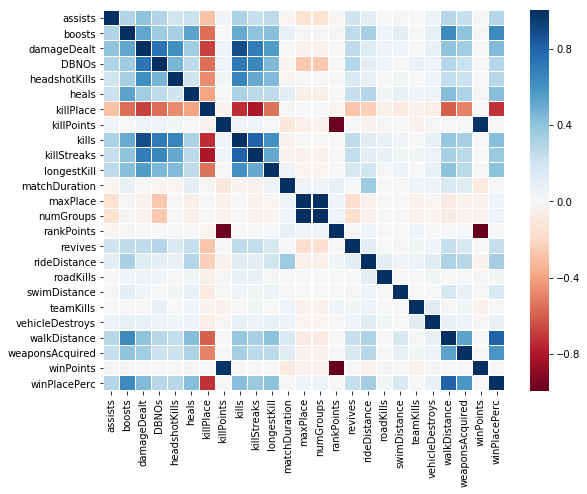

In [6]:
df = reload()

#cols_to_dropの項目を抜く
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    xticklabels = corr.columns.values,
    yticklabels = corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"    #heatmapの種類
)

plt.show()

In [7]:
df['heals'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: heals, dtype: float64

In [ ]:
#dfの中からgroupIdで各groupIdが何回か現れたか
agg = df.groupby(['groupId']).size().to_frame('players_in_team')
#dfにaggをマージ(groupIdをKeyとして)
df = df.merge(agg, how='left', on=['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
#Nanを0に置換。元のオブジェクトにも適用
df['headshotKills_over_kills'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
corr = df[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

In [ ]:
def train_test_split(df, test_size = 0.1):
    #match_idsは重複を除くユニークなmatchIdのみをリスト化したもの
    match_ids  =df['matchId'].unique().tolist()
    train_size = int(len(match_ids)*(1-test_size))
    train_match_ids = random.sample(match_ids, train_size)
    
    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def run_experiment(preprocess):
    df = reload()
    df.drop(columns={'matchType'}, inplace=True)
    
    df = preprocess(df)
    
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    train, val = train_test_split(df, 0.1)
    
    #線形回帰モデル
    model = LinearRegression()
    #モデルフィッティング（パラメータ同定）
    model.fit(train[cols_to_fit], train[target])
    
    y_true = val[target]
    #線形回帰モデルによる予測
    y_pred = model.predict(val[cols_to_fit])
    return mean_absolute_error(y_true, y_pred)

def run_experiments(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time = time.time()-start
        results.append({
            'name': preprocess.__name__,
            'score': score,
            'execution time': f'{round(execution_time,2)}s'
        })
        gc.collect()
        
    return pd.DataFrame(results, columns=['name', 
                                          'score', 
                                          'execution time']).sort_values(by='score')

In [ ]:
#オリジナルデータ
def original(df):
    return df

#回復とブーストを足したものをitemとして定義
#itemをデータに追加して線形回帰
def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how='left', on=['groupId'])

#歩行・乗り物・泳ぎを足したものをtotal_distanceとして定義
#total_distanceをデータに追加して線形回帰
def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

#歩行・乗り物・泳ぎを足したものをitemとして定義
#itemをデータに追加して線形回帰
def headshotKills_over_kills(df):
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace=True)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

In [ ]:
#入力データをいろいろ変えて線形回帰を実施
run_experiments([
    original,
    items,
    players_in_team,
    total_distance,
    headshotKills_over_kills,
    killPlace_over_maxPlace,
    walkDistance_over_heals,
    walkDistance_over_kills,
    teamwork
])

In [ ]:
def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])

In [ ]:
run_experiments([
    original,
    min_by_team,
    max_by_team,
    sum_by_team,
    median_by_team,
    mean_by_team,
    rank_by_team
])

In [4]:




print(agg)
df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])


1


C:\Users\Owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


KeyboardInterrupt: 

In [12]:
print(1)
df = reload()
cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
features = [col for col in df.columns if col not in cols_to_drop]
print(1)
agg = df.groupby(['matchId','groupId'])[features].min()

1


C:\Users\Owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


1
